## Transformer Explainability Methods

In [ ]:
# Import required modules
import torch
from transformers import AutoFeatureExtractor
from transformers import AutoModelForAudioClassification
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from azureml.fsspec import AzureMachineLearningFileSystem

# Set global font settings
plt.rcParams.update({'font.size': 25})
plt.rcParams.update({'font.family': 'serif', 'font.serif': 'Times New Roman'})
plt.tight_layout()

# Set global slice length
slice_length = 6.0

# Set visualization for bonafide or spoof
bonafide = True
spoof = not bonafide

### Load Data from Azure

In [ ]:
root_dir = "azureml:/"
fs = AzureMachineLearningFileSystem(root_dir)

metadata = pd.read_csv(root_dir+'/metadata/train_metadata.csv')

if bonafide:
    fname = metadata[metadata['KEY']=='bonafide'].iloc[0]['FLAC_FILE_NAME']
else:
    fname = metadata[metadata['KEY']=='spoof'].iloc[0]['FLAC_FILE_NAME']


In [ ]:
# Load test audio file
audio_file = fs.open(root_dir+'flac_T/'+fname+'.flac', 'r')
audio, sr = librosa.load(audio_file, sr=16000)
audio = audio[:int(sr*slice_length)]

In [ ]:
# Play audio if desired
import IPython
IPython.display.Audio(audio, rate=sr)

### Occlusion with AST

In [ ]:
# Load model from Azure filesystem
model_dir = f"azureml://checkpoint/"
model_fs = AzureMachineLearningFileSystem(model_dir)

feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

In [ ]:
# Preprocess the audio into spectrogram
inputs = feature_extractor(audio, sampling_rate=sr, return_tensors="pt", padding=False)

In [ ]:
# Copy model to local directory
local_dir = '../temp_model'

os.makedirs(local_dir, exist_ok=True)

# Download the model files
for file in model_fs.ls(local_dir, detail=False, recursive=True):
    if model_fs.isfile(file):  # Only process files, not directories
        file_name = os.path.basename(file)
        model_fs.get(file, local_dir)

In [ ]:
# Instantiate the model
model = AutoModelForAudioClassification.from_pretrained(local_dir, output_attentions=True, output_hidden_states=True)

In [ ]:
# Visualize the features
features = inputs['input_values'].squeeze().numpy()
plt.figure(figsize=(10, 6))
plt.imshow(features.T, aspect='auto', origin='lower', cmap='jet')
plt.colorbar(label='Amplitude')
plt.title("AST Feature Extractor Output")
plt.xlabel("Time (frames)")
plt.ylabel("Frequency bins")
plt.show()

In [ ]:
import torch.nn.functional as F

def occlusion_with_probability_change(inputs, model, occlusion_size=(200, 50), stride=(100, 25)):
    # Extract the original logits and get the softmax probabilities
    original_logits = model(**inputs).logits
    original_probs = F.softmax(original_logits, dim=-1)
    original_prediction = torch.argmax(original_probs, dim=-1).item()
    original_prob_predicted_class = original_probs[0, original_prediction].item()

    # Copy the spectrogram to perform occlusions
    spectrogram = inputs['input_values'][0].unsqueeze(0).clone()

    print(spectrogram.size())

    # Initialize heatmap for storing changes in probability
    heatmap = np.zeros((spectrogram.size(1), spectrogram.size(2)))

    # Occlude different parts of the spectrogram and measure probability changes
    for i in range(0, spectrogram.size(1) - occlusion_size[0] + 1, stride[0]):
        for j in range(0, spectrogram.size(2) - occlusion_size[1] + 1, stride[1]):
            # Clone the spectrogram and occlude the patch
            print(i,j)
            occluded_spectrogram = spectrogram.clone()
            occluded_spectrogram[:, i:i+occlusion_size[0], j:j+occlusion_size[1]] = 0

            # Get the logits and probabilities after occlusion
            occluded_inputs = {'input_values': occluded_spectrogram}
            occluded_logits = model(**occluded_inputs).logits
            occluded_probs = F.softmax(occluded_logits, dim=-1)
            occluded_prob_predicted_class = occluded_probs[0, original_prediction].item()

            # Calculate the difference in probability for the predicted class
            prob_diff = original_prob_predicted_class - occluded_prob_predicted_class

            # Store the difference in the heatmap (higher difference = more important region)
            print(prob_diff)
            
            heatmap[i:i+occlusion_size[0], j:j+occlusion_size[1]] += abs(prob_diff)

    return heatmap

heatmap = occlusion_with_probability_change(inputs, model)


In [ ]:
# Visualize resultant heatmap
def visualize_occlusion(heatmap, inputs):
    spectrogram = inputs['input_values'][0].squeeze().numpy()
    heatmap = heatmap.squeeze()

    plt.figure(figsize=(10, 6))
    plt.imshow(spectrogram.T, aspect='auto', origin='lower', cmap='Greys')
    plt.imshow(heatmap.T, aspect='auto', origin='lower', cmap='jet', alpha=0.5)
    plt.colorbar(label='Importance')
    # plt.title("Spectrogram with Occlusion Heatmap")
    plt.xlabel("Time Frames")
    plt.ylabel("Frequency Bins")
    plt.show()

# Visualize
visualize_occlusion(heatmap, inputs)


## Attention Visualization with Wav2Vec

In [ ]:
# Load model from local
model_name = f"{int(slice_length)}/checkpoint/"
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")

# Preprocess the audio into spectrogram
inputs = feature_extractor(audio, sampling_rate=sr, return_tensors="pt", padding=False)

# Instantiate model
model = AutoModelForAudioClassification.from_pretrained(model_name, output_attentions=True, output_hidden_states=True)

In [82]:
outputs = model(**inputs)
attentions = outputs.attentions

In [83]:
# Visualize attention per layer per head (here, we have only one head)
layer_num = -1
head_num = 0
attention_weights = torch.mean(attentions[layer_num][head_num], dim=0).detach().numpy()

0.0033444816
0.00033523844


(array([  583.,  5089., 13005., 14779., 24070., 16652., 10390.,  3900.,
          878.,    55.]),
 array([0.00239914, 0.00261161, 0.00282408, 0.00303655, 0.00324902,
        0.00346149, 0.00367396, 0.00388643, 0.0040989 , 0.00431137,
        0.00452384]),
 <BarContainer object of 10 artists>)

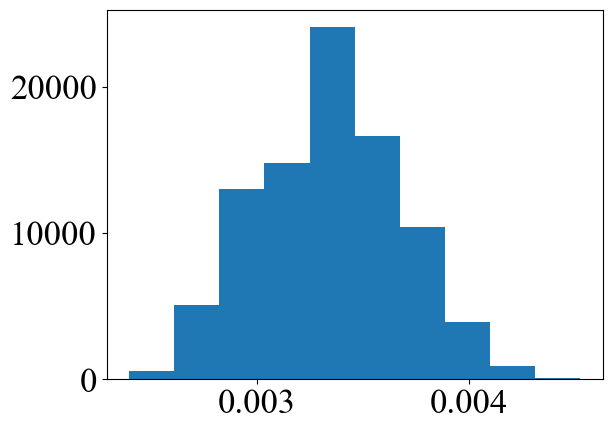

In [84]:
plt.hist(attention_weights.flatten())

0.44492903
0.15778126


(array([  583.,  5089., 13005., 14779., 24070., 16652., 10390.,  3900.,
          878.,    55.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

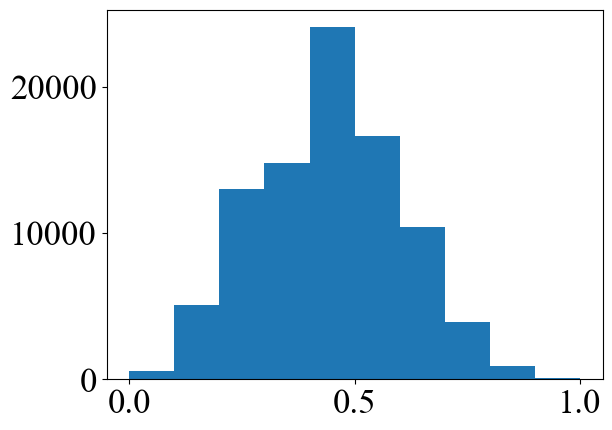

In [85]:
normalized_attention_weights = (attention_weights - np.min(attention_weights)) / (np.max(attention_weights) - np.min(attention_weights))
plt.hist(normalized_attention_weights.flatten())

In [86]:
# This is to see where the most attention is concentrated
# The final sum gives us a sense of how distributed vs. concentrated the attention is
from itertools import compress

over = [a > 0.8 for a in normalized_attention_weights.ravel()]
over_idx = np.where(np.array(over))[0]
for idx in over_idx:
    print(np.unravel_index(idx, attention_weights.shape))

sum(over)

(0, 84)
(1, 84)
(2, 84)
(2, 85)
(3, 84)
(4, 84)
(4, 85)
(5, 84)
(5, 85)
(5, 295)
(6, 84)
(6, 85)
(7, 84)
(7, 85)
(7, 295)
(8, 84)
(8, 85)
(9, 84)
(9, 85)
(10, 84)
(10, 85)
(11, 84)
(11, 85)
(12, 84)
(13, 84)
(13, 85)
(13, 295)
(14, 84)
(15, 84)
(16, 84)
(17, 84)
(18, 84)
(19, 84)
(20, 84)
(21, 84)
(21, 85)
(22, 84)
(22, 85)
(22, 295)
(23, 84)
(23, 85)
(23, 295)
(24, 84)
(24, 85)
(24, 295)
(25, 84)
(25, 85)
(25, 295)
(26, 84)
(26, 85)
(26, 295)
(27, 84)
(27, 85)
(27, 215)
(27, 295)
(28, 84)
(28, 85)
(28, 215)
(28, 295)
(29, 84)
(29, 85)
(29, 199)
(29, 215)
(29, 295)
(30, 84)
(30, 85)
(30, 199)
(30, 215)
(30, 295)
(31, 84)
(31, 85)
(31, 215)
(32, 84)
(32, 85)
(32, 199)
(32, 215)
(32, 295)
(33, 84)
(33, 85)
(33, 215)
(33, 295)
(34, 84)
(34, 215)
(34, 295)
(35, 84)
(35, 85)
(35, 169)
(35, 215)
(35, 295)
(36, 84)
(36, 85)
(36, 169)
(36, 215)
(36, 295)
(37, 84)
(37, 85)
(37, 169)
(37, 215)
(37, 295)
(38, 42)
(38, 67)
(38, 84)
(38, 85)
(38, 169)
(38, 182)
(38, 215)
(38, 295)
(39, 42)
(39, 84)

933

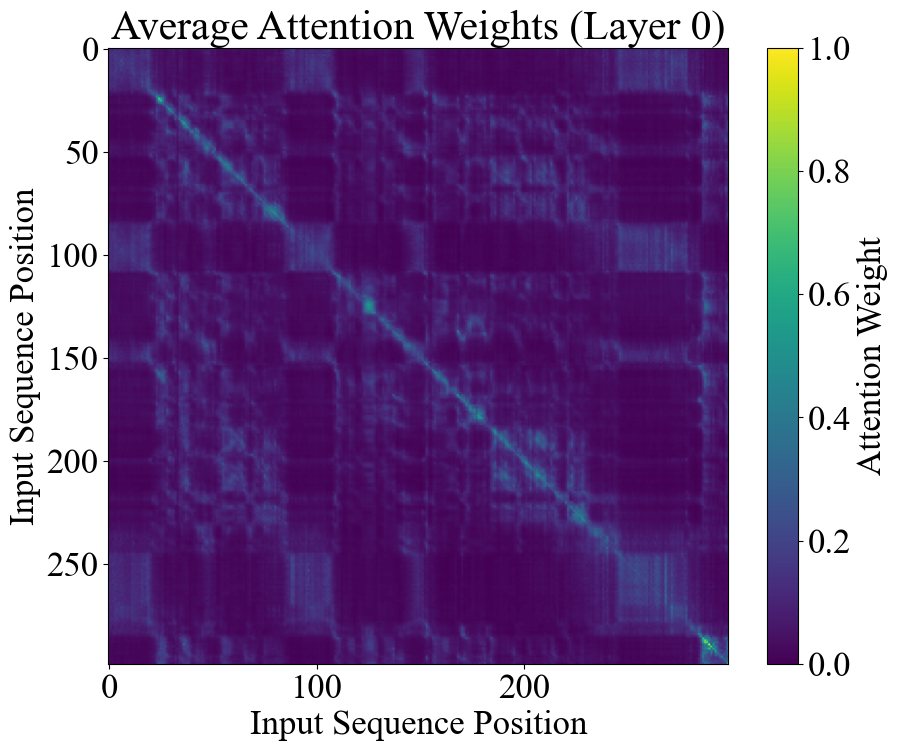

In [87]:
# Visualize the averaged attention weights
attention_weights = torch.mean(attentions[layer_num][head_num], dim=0).detach().numpy()
attention_weights = (attention_weights - np.min(attention_weights)) / (np.max(attention_weights) - np.min(attention_weights))
plt.figure(figsize=(10, 8))
plt.imshow(attention_weights, cmap='viridis', aspect='auto') # vmin=0.0, vmax=0.15
plt.colorbar(label='Attention Weight')
plt.title(f"Average Attention Weights (Layer {layer_num})")
plt.xlabel("Input Sequence Position")
plt.ylabel("Input Sequence Position")
plt.show()

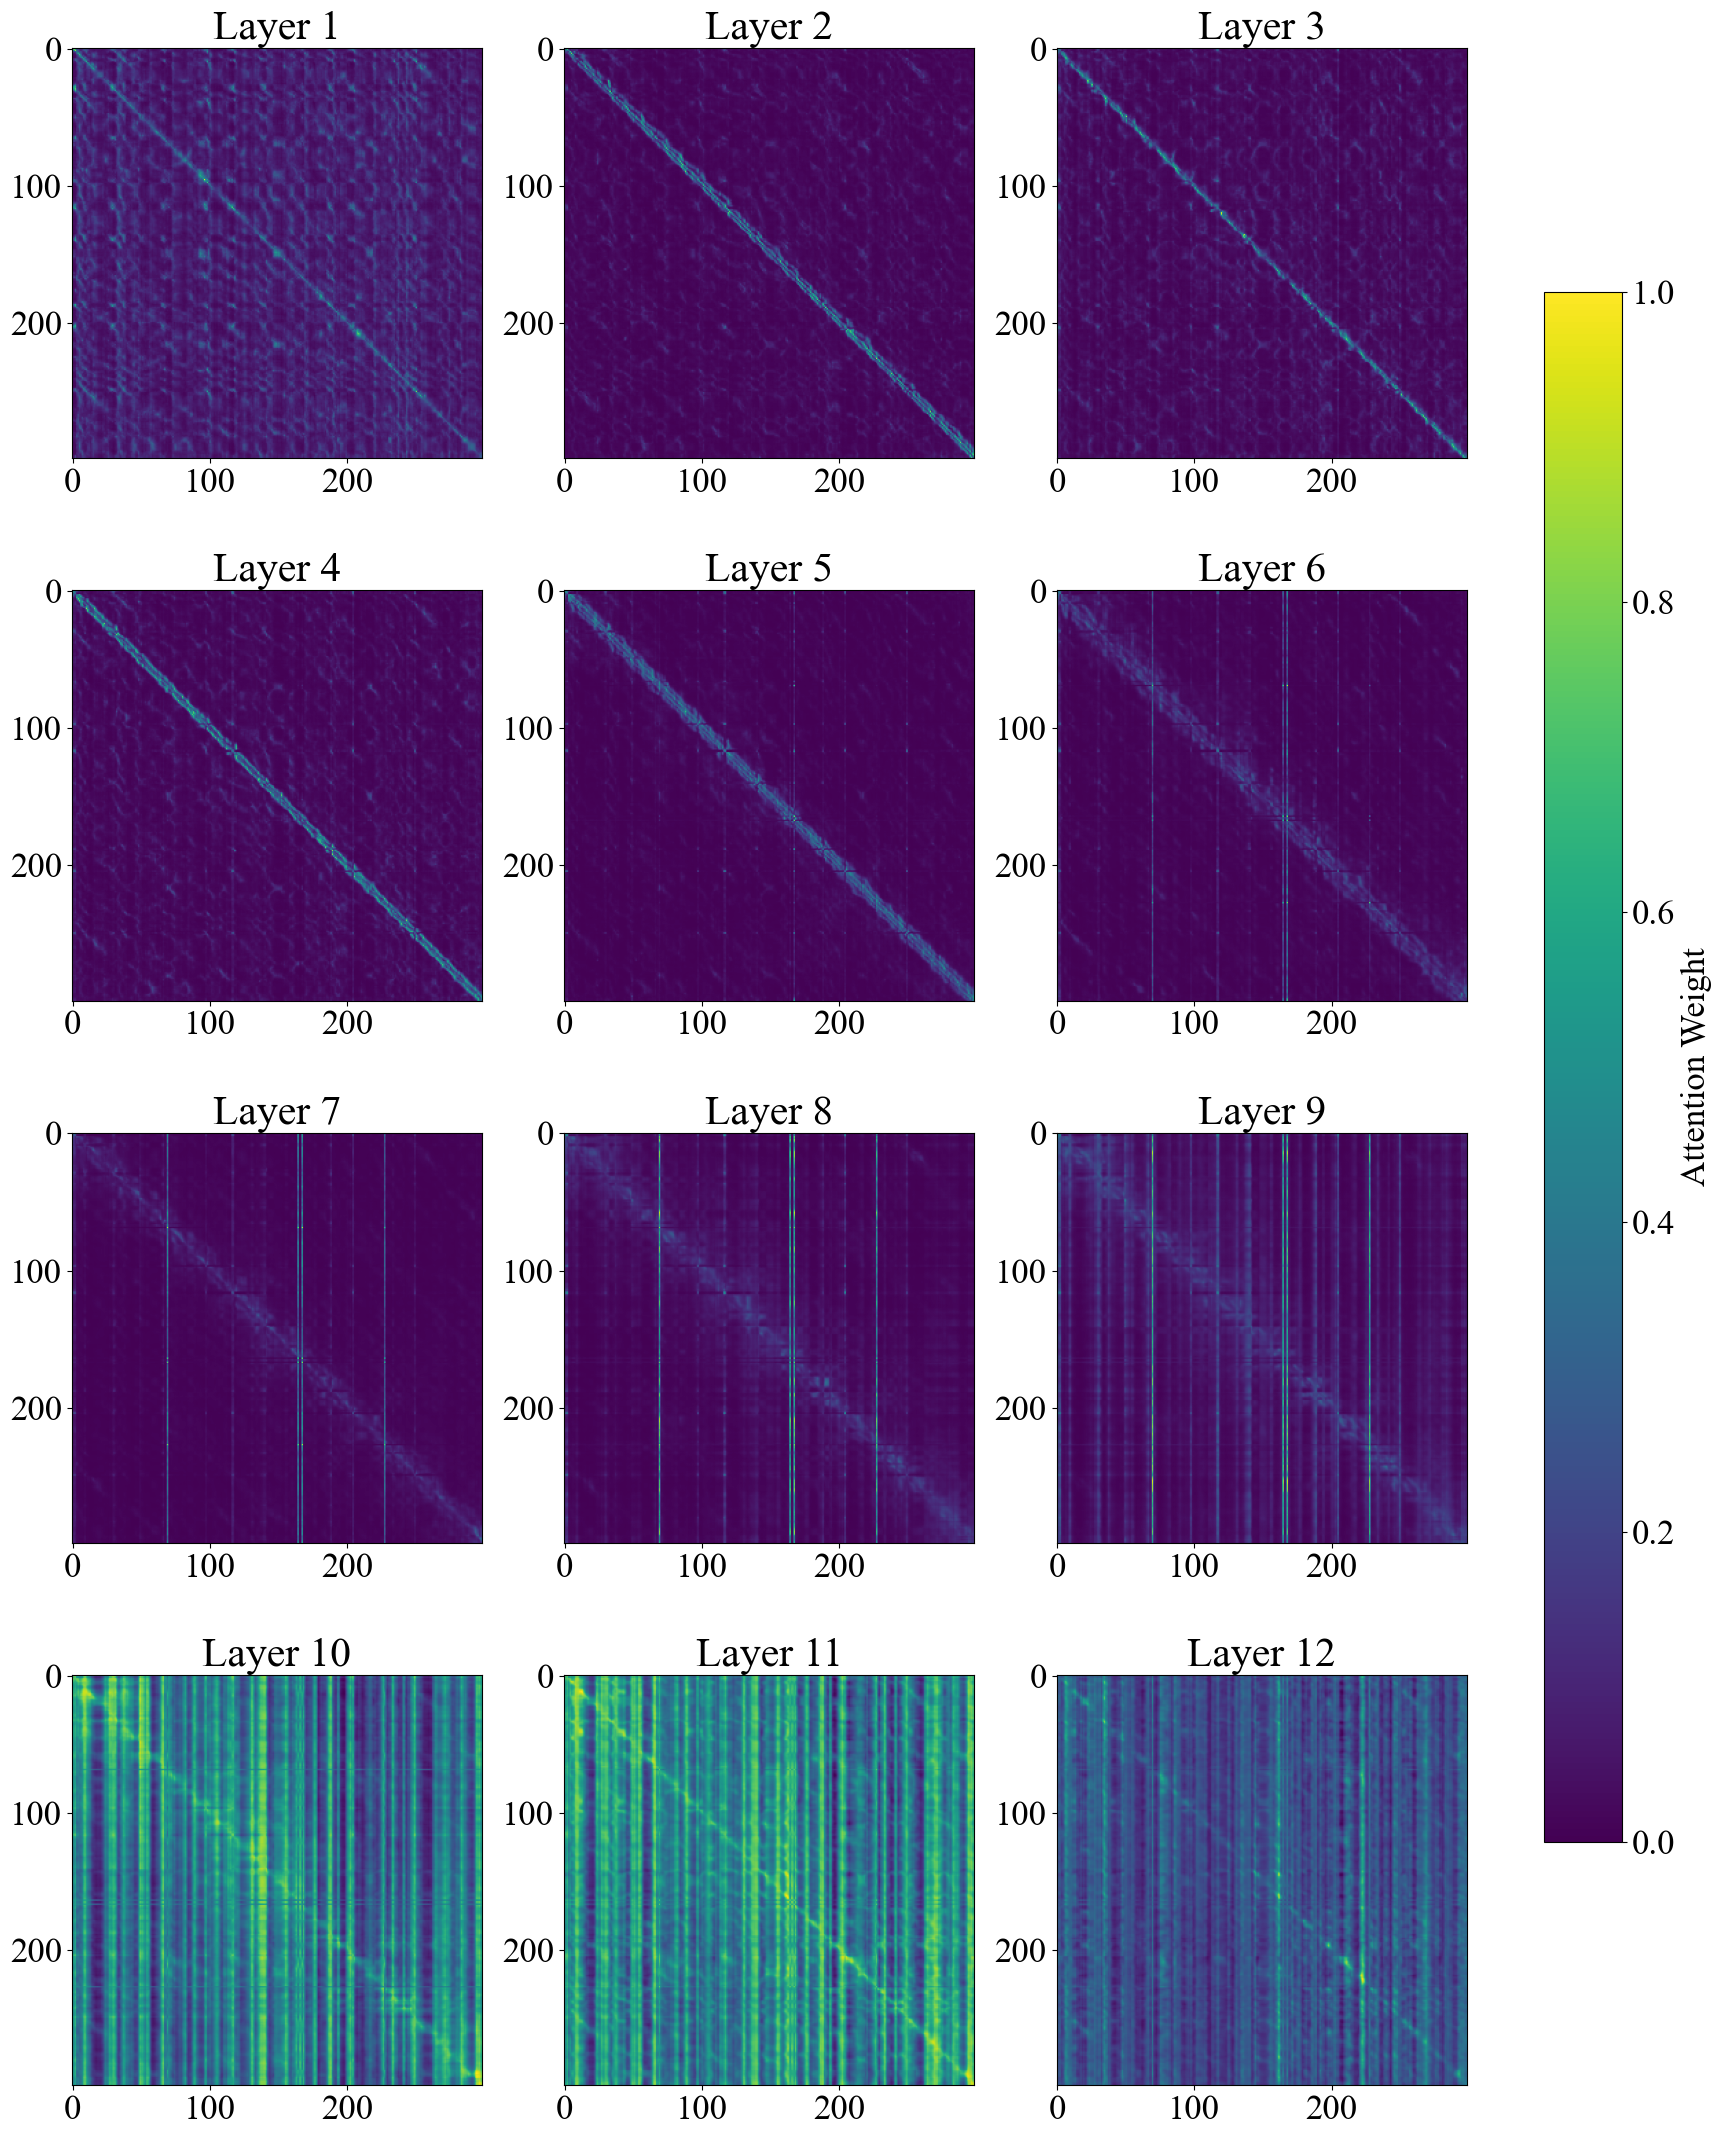

In [48]:
fig, axes = plt.subplots(4, 3, figsize=(20, 27))

for i in range(12):
    attention_weights = torch.mean(attentions[i][0], dim=0).detach().numpy()
    attention_weights = (attention_weights - np.min(attention_weights)) / (np.max(attention_weights) - np.min(attention_weights))  # Normalize the values

    # Get the corresponding axis in the grid
    ax = axes[i // 3, i % 3]  # Map head i to the correct subplot

    # Plot the attention weights in the current axis
    im = ax.imshow(attention_weights, cmap='viridis', aspect='equal')

    # Add title and labels
    ax.set_title(f"Layer {i+1}")
    ax.set_xlabel("Input Sequence Position")
    ax.set_ylabel("Input Sequence Position")


cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.05, pad=0.05)
cbar.set_label('Attention Weight')

# Adjust layout to avoid overlapping plots
plt.show()

In [88]:
def compute_attention_rollout(attentions):
    # Start with identity matrix for the last layer
    rollout = torch.eye(attentions[0].size(-1)).to(attentions[0].device)
    
    # For each layer, multiply the current attention matrix with the cumulative rollout
    for attention in attentions:
        # Average attention across all heads
        attention_heads_fused = attention.mean(dim=1)
        
        # Add a residual connection and normalize
        attention_heads_fused = attention_heads_fused + torch.eye(attention_heads_fused.size(-1)).to(attention_heads_fused.device)
        attention_heads_fused = attention_heads_fused / attention_heads_fused.sum(dim=-1, keepdim=True)
        
        # Multiply with the previous rollout matrix
        rollout = torch.matmul(attention_heads_fused, rollout)
    
    return rollout

# Compute attention rollout
attention_map = compute_attention_rollout(outputs.attentions)


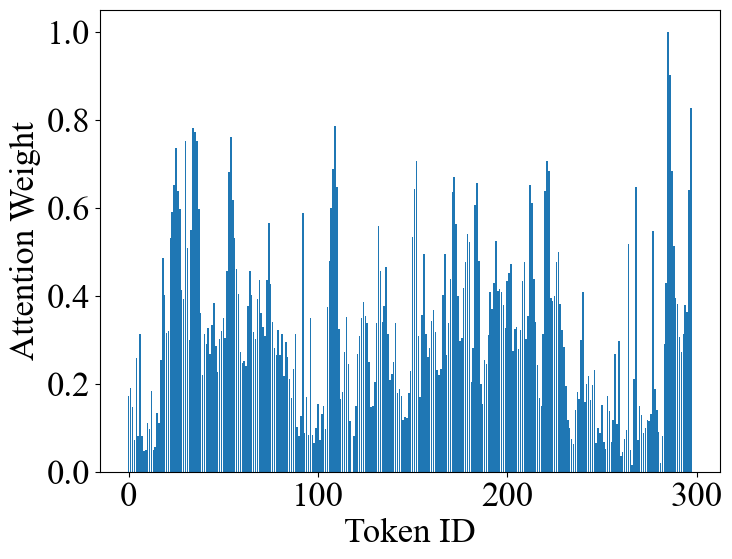

In [91]:
# Visualize attention roll-out
from torch.nn.functional import normalize

m = attention_map[0, 0, 1:].detach().numpy()
n = (m - np.min(m)) / (np.max(m) - np.min(m))

plt.figure(figsize=(8, 6))
plt.bar(range(len(n)), n)

plt.xlabel('Token ID')
plt.ylabel('Attention Weight')

# Display the plot
plt.show()
